## Dependencies

In [ ]:
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# -- Change this as per your data directory --#
data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')


file_list_path = os.path.join(data_path,'FileList.csv')
volume_tracings_path = os.path.join(data_path,'VolumeTracings.csv')
videos_path = os.path.join(data_path,'Videos')

os.chdir('../')
from src.dataloader import EchoMaskDataset, build_polygons_dict
%pwd

<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\P'
C:\Users\harsh\AppData\Local\Temp\ipykernel_10756\878745760.py:12: SyntaxWarning: invalid escape sequence '\P'
  data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')


'c:\\Projects\\python\\echoframe_capstone'

In [2]:
file_list = pd.read_csv(filepath_or_buffer=file_list_path)
volume_tracings = pd.read_csv(filepath_or_buffer=volume_tracings_path)


In [3]:
volume_tracings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425010 entries, 0 to 425009
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FileName  425010 non-null  object 
 1   X1        425010 non-null  float64
 2   Y1        425010 non-null  float64
 3   X2        425010 non-null  float64
 4   Y2        425010 non-null  float64
 5   Frame     425010 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 19.5+ MB


## Dataset preprocessing

### Handling missing files and outliers

In [4]:
file_list['FileName'] = file_list['FileName'].apply(
    lambda x: x if x.endswith('.avi') else x + '.avi'
)
vt_filenames = set(volume_tracings['FileName'])
fl_filenames = set(file_list['FileName'])

missing_files = list(fl_filenames - vt_filenames)
extra_files = list(vt_filenames - fl_filenames)

print(f'Missing files: \n{missing_files}\n\nExtra files: \n{extra_files}')
redacted_files = missing_files+extra_files

redacted_files

Missing files: 
['0X35291BE9AB90FB89.avi', '0X6C435C1B417FDE8A.avi', '0X234005774F4CB5CD.avi', '0X5DD5283AC43CCDD1.avi', '0X2DC68261CBCC04AE.avi', '0X5515B0BD077BE68A.avi']

Extra files: 
['0X4F8859C8AB4DA9CB.avi']


['0X35291BE9AB90FB89.avi',
 '0X6C435C1B417FDE8A.avi',
 '0X234005774F4CB5CD.avi',
 '0X5DD5283AC43CCDD1.avi',
 '0X2DC68261CBCC04AE.avi',
 '0X5515B0BD077BE68A.avi',
 '0X4F8859C8AB4DA9CB.avi']

In [5]:
file_list = file_list[~file_list['FileName'].isin(redacted_files)]
volume_tracings = volume_tracings[~volume_tracings['FileName'].isin(redacted_files)]

### Train test and val splits

In [6]:
train_df = file_list[file_list['Split'] == 'TRAIN']
val_df   = file_list[file_list['Split'] == 'VAL']
test_df  = file_list[file_list['Split'] == 'TEST']

## Data Loader

In [7]:
polygons_dict = build_polygons_dict(volume_tracings_path)
polygons_dict

{('0X100009310A3BD7FC',
  46): [[(51.26041667, 15.34895833),
   (64.93229167, 69.125),
   (50.03761083, 17.16784126),
   (53.36722189, 16.32132997),
   (49.15737821, 20.40762939),
   (57.09054885, 18.3907216),
   (48.5381733, 23.58105455),
   (59.99733911, 20.66770731),
   (47.91896839, 26.7544797),
   (62.90412937, 22.94469301),
   (47.9621045, 29.75951307),
   (65.81091963, 25.22167871),
   (48.16791529, 32.72318847),
   (68.24704281, 27.61832554),
   (48.37372608, 35.68686387),
   (70.38531105, 30.0906982),
   (48.57953687, 38.65053927),
   (72.5235793, 32.56307085),
   (49.01403934, 41.55607271),
   (74.15164369, 35.16515635),
   (49.83099892, 44.3643713),
   (75.71299787, 37.78420208),
   (50.64795851, 47.17266989),
   (77.27435205, 40.4032478),
   (51.4649181, 49.98096847),
   (78.64469427, 43.07085589),
   (52.54732826, 52.72177963),
   (79.48537463, 45.87312377),
   (53.7042693, 55.44364225),
   (80.326055, 48.67539165),
   (54.36563, 58.29149988),
   (80.609375, 51.61936132),


In [8]:
train_dataset = EchoMaskDataset(
    df=train_df,
    polygons_dict=polygons_dict,
    videos_path=videos_path,
    transform=None,         # or pass a custom transform
    resize=(112, 112),
    all_traced_frames=True,
    offset_frames_by_one=False
)

val_dataset = EchoMaskDataset(
    df=val_df,
    polygons_dict=polygons_dict,
    videos_path=videos_path,
    transform=None,       
    resize=(112, 112),
    all_traced_frames=True,
    offset_frames_by_one=False
)

# Wrap in DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=16)


In [9]:
len(train_loader)*8

14920

## Visualize

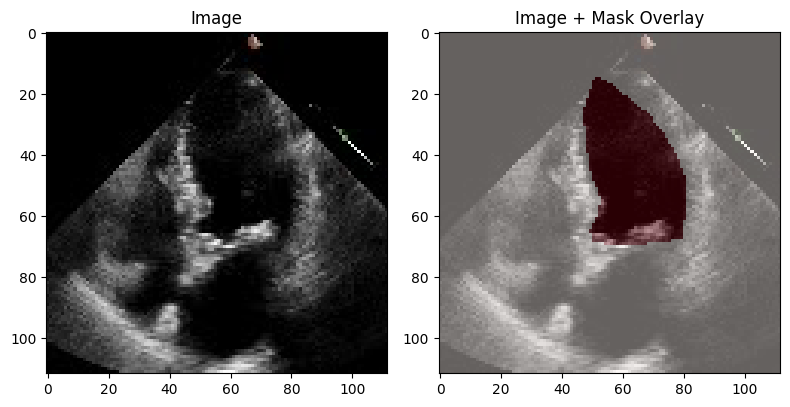

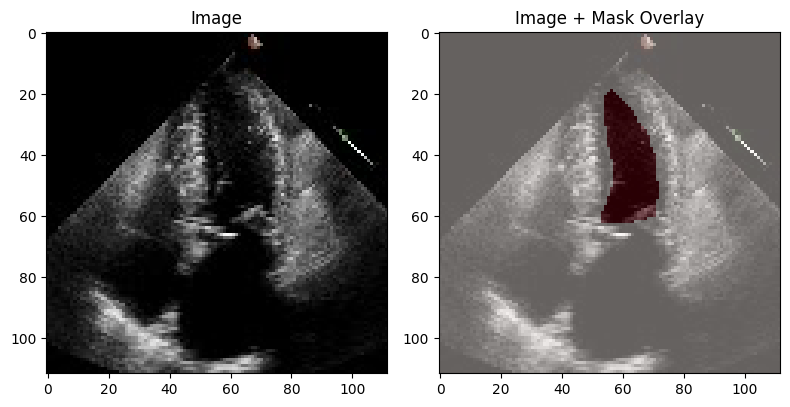

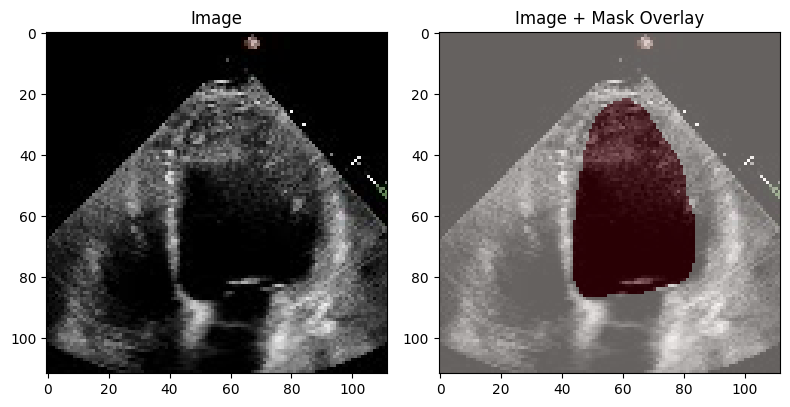

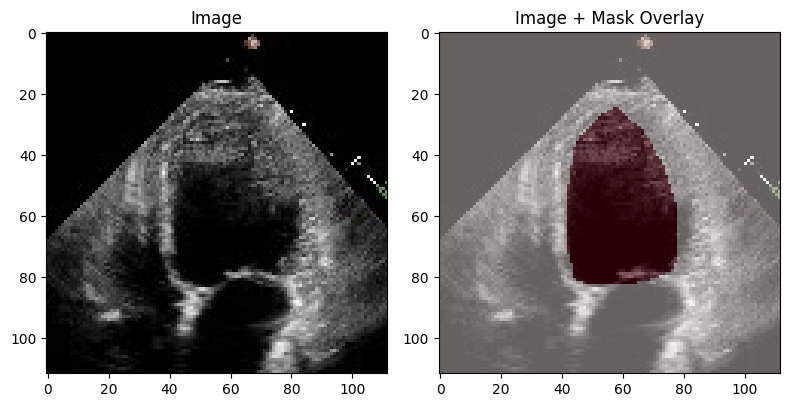

In [10]:
# Get one batch
for images, masks in val_loader:
    # Plot first 4 samples from the batch
    num_samples = min(4, images.shape[0])
    for i in range(num_samples):
        img = images[i]         
        mask = masks[i]         

        # convert tensors to numpy for plotting
        img_np = TF.to_pil_image(img)
        mask_np = TF.to_pil_image(mask.squeeze(0))  # make it (H, W)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title("Image")
        plt.imshow(img_np)

        plt.subplot(1, 2, 2)
        plt.title("Image + Mask Overlay")
        plt.imshow(img_np)
        plt.imshow(mask_np, alpha=0.4, cmap='Reds')  # Overlay mask
        plt.tight_layout()
        plt.show()
    break
